# Assess Solar PV mapped in Open Street Map 

In [85]:
# Setup
import os
import codecs
import pandas as pd
import requests
import collections
import re
import json
import pickle
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Polygon, Point, asShape

### Try to query Overpass programatically and get some useful info out

In [133]:
# Adapted from Sylwia
# https://github.com/SylwiaOliwia2/uk-photovoltaics-map/blob/master/data_preprocessing/functions_panels_amount.py

def getSolarPanelsFromOSM(osm_from_pickle=False, folder_with_output_files='data', picklename="osm_panels"):
    '''
    Query OpenStreetMap to get all solar panels within a country. Optionally - load pickled data
    :param osm_from_pickle: bool, if Solar Panels data should be loaded from pickle instead of querying from OSM.
            data from pickle are faster, but may be outdated. Should be used for development purposes or when unable to query OSM
    :param folder_with_output_files: name of the folder with preprocessed federal data (stored as multiple CSV).
            Name without the path. Folder should be located in the same directory as functions_panels_amount file.
    :param picklename: filename where data will be pickled
    :return: json with node coordinates
    '''
    dirname = ''
    print("Query Open Street Map for solar panels in the UK.")
    if osm_from_pickle:
        # TODO: if no pickled data in folder- query OSM
        with open(os.path.join(dirname, folder_with_output_files, "panels.pkl"), 'rb') as f:
            osm_queried_panels = pickle.load(f)
    else:
        overpass_url = "http://overpass-api.de/api/interpreter"

        ######### query all solar panels saved as polygon
        solar_ways_query = """
            [out:json];
            area["name"="United Kingdom"]->.searchArea;
            (
            way(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];
            );
            out body;
            >;
            out skel qt;
        """
        ways_solar = requests.get(overpass_url, params={'data': solar_ways_query}).json()

        # to simplify, one polygon will be represented as one panel
        # the panel will get coordinates of the first node of polygon
        first_node_ids = [element["nodes"][0] for element in ways_solar["elements"] if element["type"] == "way"]
        panels_from_polygon = [element for element in ways_solar["elements"] if element["id"] in first_node_ids]

        ######## query all solar panels saved as points (nodes)
        solar_nodes_query = """
            [out:json];
            area["name"="United Kingdom"]->.searchArea;
            (
             node(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];
            );
            out body;
            >;
            out skel qt;
        """
        panels_from_nodes = requests.get(overpass_url, params={'data': solar_nodes_query}).json()

        osm_queried_panels = panels_from_nodes["elements"] + panels_from_polygon
        osm_queried_panels = ways_solar['elements']

        with open(os.path.join(dirname, folder_with_output_files, picklename + ".pkl"), 'wb') as f:
            pickle.dump(osm_queried_panels, f)
    print("Done.")

    return osm_queried_panels

In [134]:
osm_pv = getSolarPanelsFromOSM(osm_from_pickle=False, folder_with_output_files='data', picklename="panels")

Query Open Street Map for solar panels in the UK.
Done.


In [135]:
osm_df = pd.DataFrame(osm_pv)
print(len(osm_df))
osm_df.groupby('type').count()

65859


,id,lat,lon,nodes,tags
type,,,,,
node,57423,57423,57423,0,0
way,8436,0,0,8436,8436


In [154]:
osm_df['geometry'] = list(zip(osm_df['lon'], osm_df['lat']))
osm_df['geometry'] = osm_df['geometry'].apply(lambda x: Point(x))
osm_df = gpd.GeoDataFrame(osm_df, crs={'init': 'epsg:4326'}) # OSM comes in this coordinate system

In [155]:
# Change to British National Grid coordinates
osm_bng = osm_df.to_crs({'init':'epsg:27700'})

### Plot

In [156]:
# Get Great Britain shapefile from here (5mb download) if desired and unzip in project root directory
# Select 'United Kingdom' and 'Administrative Area'
# http://www.diva-gis.org/gdata

# Grab UK outline (crs epsg:4326) and change to BNG coordinates
gb_outline = gpd.read_file('GBR_adm/GBR_adm1.shp').to_crs({'init':'epsg:27700'})

(-344296.4836098958, 703314.2320738147, -59103.1256864278, 1360151.8978189533)

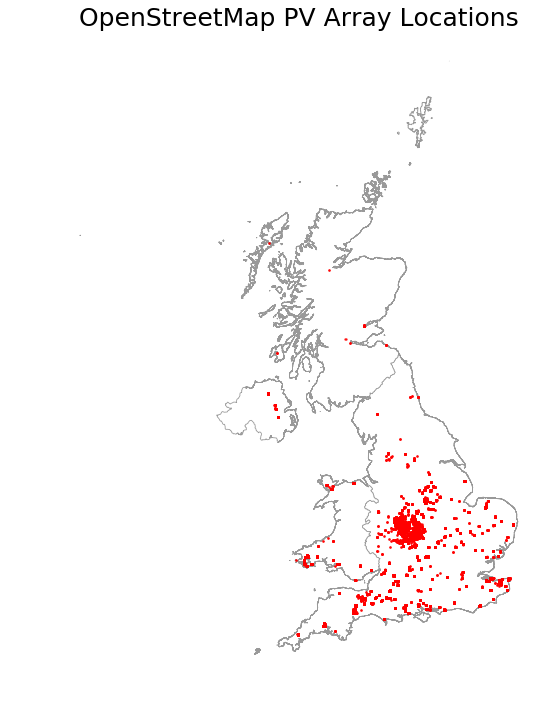

In [157]:
# Plot 
fig, ax = plt.subplots(1, figsize=(12, 12))
gb_outline.plot(ax=ax, color='white', linewidth=0.8, edgecolor='0.6')
osm_bng.plot(ax=ax, markersize=2, color='red', alpha=0.4)

ax.set_title("OpenStreetMap PV Array Locations", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

### Plot interactively
Folium wants WGS 84 coordinates so we can use the original dataframe, rather than `osm_bng`  
However, plotting >1000 polygons seems to freeze the leaflet map up.  
Plotting >6000 points also doesn't work well
And polygons are also too small to see at any reasonable zoom level.  
The `osm_df` from above is all points anyway. 

In [185]:
len(osm_df[osm_df['lat'].isna()])

8436

In [211]:
# Lots of points that I don't understand - they have been converted from the ways??
osm_folium = osm_df[osm_df.lat.notna()]

In [229]:
print(len(osm_folium))
osm_folium.head(1)

57423


,id,lat,lon,nodes,tags,type,geometry
8436,6382871874,50.302158,-5.140352,NaN,NaN,node,POINT (-5.1403517 50.3021577)


Fun but falls over at >5000 points which is a shame.  
TODO: Reduce number of nodes from above (unsure why there are so many) OR  
combine points by distance somehow (probably back into the real arrays

In [241]:
# https://ocefpaf.github.io/python4oceanographers/blog/2015/12/14/geopandas_folium/
import folium
from folium import IFrame
from folium.plugins import MarkerCluster

# Check out map
m = folium.Map([50.751, -1.9950], zoom_start=6, tiles='cartodbpositron')

locations = []
for idx, row in osm_folium[:5000].iterrows():
    locations.append([row['geometry'].y, row['geometry'].x])
    
s = folium.FeatureGroup(name='Solar PV')
s.add_children(MarkerCluster(locations=locations))
m.add_children(s)

/Users/laurence/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  
/Users/laurence/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  from ipykernel import kernelapp as app


###  Try to fiddle around with polygons to get area but it doesn't go that well

In [4]:
overpass_url = "http://overpass-api.de/api/interpreter"

In [5]:
solar_ways_query = """
            [out:json];
            area["name"="United Kingdom"]->.searchArea;
            (
            way(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];
            node(area.searchArea)["generator:source"="solar"]['generator:output:electricity'='yes'];
            );
            out body;
            >;
            out skel qt;
        """

In [101]:
ways_solar = requests.get(overpass_url, params={'data': solar_ways_query}).json()

In [102]:
osm = pd.DataFrame(ways_solar['elements'])

In [103]:
osm.groupby('type').count()

,id,lat,lon,nodes,tags
type,,,,,
node,57423,57423,57423,0,0
way,8436,0,0,8436,8436


In [116]:
ways = osm[osm.type=='way']

In [117]:
ways['geometry'] = ways['nodes']

/Users/laurence/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [118]:
ways = gpd.GeoDataFrame(ways)

In [119]:
ways['geometry'].head()
# Not quite right

0    [320803617, 320803618, 320803619, 5269455022, ...
1    [486078905, 486078907, 486078909, 486078911, 4...
2    [693292683, 1505138122, 1505138120, 693292682,...
3    [718622697, 1979037794, 1979037796, 718622676,...
4    [718828944, 1104741476, 1104741246, 1104740895...
Name: geometry, dtype: object

## Better way: Export geojson from Overpass

The above method returns a mix of ways and points, all cast into points.  
If I make the query with requests and return as json the geometries are in an annoying format.  
TODO Fix query so it returns geojson  

Instead, go to https://overpass-turbo.eu/, use the solar queries above and then click 'export', then select geojson.  
The resulting export file will then be well-behaved for plotting / calculating areas. 

In [108]:
export = gpd.read_file('export.geojson')

In [120]:
export.head(1)

,id,@id,building,generator:method,generator:output:electricity,generator:source,generator:type,name,power,tourism,...,source:geometry,generator:output:hot_water,latest_start_date,repd:id,pv_module_array,height,generator:output:biogas,orientation,highway,geometry
0,way/29169304,way/29169304,yes,photovoltaic,yes,solar,solar_photovoltaic_panel,Hag Dyke Scout Hostel,generator,hostel,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-2.0170962 54.1557915, -2.0170983 54..."


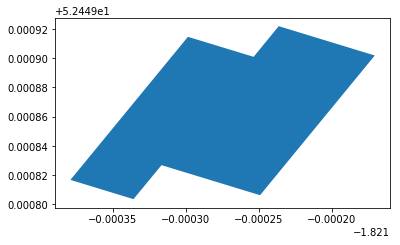

In [114]:
export[3:4].plot()

In [121]:
export.count()

id                              8436
@id                             8436
building                        3066
generator:method                8423
generator:output:electricity    8436
generator:source                8436
generator:type                  8329
name                              44
power                           8432
tourism                            3
amenity                           14
note                             503
source                          3432
addr:city                        473
addr:housenumber                 296
addr:postcode                    466
addr:street                      488
location                        2938
shop                               4
addr:place                        30
addr:housename                     6
ref:edubase                        1
operator                        2000
fhrs:id                            1
wheelchair                         1
fixme                             38
addr:country                       8
w

A small number of these polygons do have notional areas.  
We can infer area from the polygon, after converting into a cartesian system (ie in meters)  
TODO: check this is correct

In [122]:
# Convert to Cartesian system (EPSG:3857, unit= m)              
export2 = export.copy()
export2 = export2.to_crs({'init': 'epsg:3857'})
export2["area"] = export2['geometry'].area

Text(0.5, 1.0, 'OSM Arrays all')

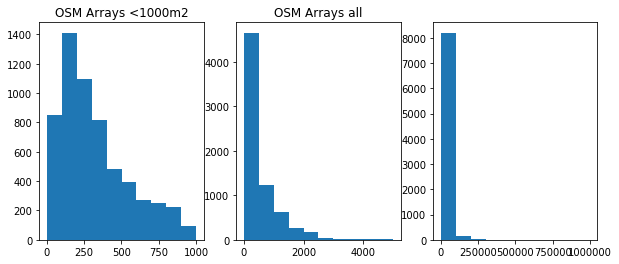

In [124]:
# Assess distribution
f, ax = plt.subplots(1, 3, figsize=(10,4)) 
ax[0].hist(export2[export2['area'] < 1000]['area'])
ax[1].hist(export2[export2['area'] < 5000]['area'])
ax[2].hist(export2['area'])
ax[0].set_title('OSM Arrays <1000m2')
ax[1].set_title('OSM Arrays <5000m2')
ax[1].set_title('OSM Arrays all')

a 4kW array is around 29m2  
ie around 1kW per 7.5m2

In [125]:
export2['size'] = export2['area']/7.5

(array([ 56.,  81.,  68., 463.,  52.,  92.,  47., 106., 239., 273.]),
 array([ 0.3611329 ,  2.32352197,  4.28591103,  6.2483001 ,  8.21068917,
        10.17307823, 12.1354673 , 14.09785637, 16.06024543, 18.0226345 ,
        19.98502357]),
 <a list of 10 Patch objects>)

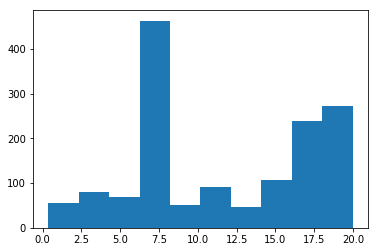

In [126]:
plt.hist(export2[export2['size']<20]['size'])

It seems much more likely that this spike is the 4kw array size cutoff.  
So probably there is a mistake in the above steps. 

In [131]:
len(export2[export2['size']<50]), len(export2[export2['size']<100])

(3933, 5418)

So, even with worries about size accuracy, we have around 4k PV polygons sized maybe under 50-100kW, and 5.4k under 100-200kW